In [2]:
import pandas as pd


In [4]:
df_luis=pd.read_csv('/content/sample_data/barca_filtered_events_luis.csv')
df_valverde=pd.read_csv('/content/sample_data/barca_filtered_events_after.csv')

In [5]:
# Define the reliable defensive event types you've chosen
reliable_defensive_events = ['Duel', 'Interception', 'Clearance']

#  For Luis Enrique's Era
luis_defensive_actions = df_luis[df_luis['event_type'].isin(reliable_defensive_events)]

#  For Ernesto Valverde's Era
valverde_defensive_actions = df_valverde[df_valverde['event_type'].isin(reliable_defensive_events)]

# Let's verify our new datasets
print(f"Luis Enrique  Total Defensive Actions: {len(luis_defensive_actions)}")
print(f"Ernesto Valverde  Total Defensive Actions: {len(valverde_defensive_actions)}")
print("\nUnique event types included:")
print(luis_defensive_actions['event_type'].unique())

Luis Enrique - Total Defensive Actions: 6698
Ernesto Valverde - Total Defensive Actions: 5201

Unique event types included:
['Duel' 'Clearance' 'Interception']


In [6]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 3.6 MB/s eta 0:00:00


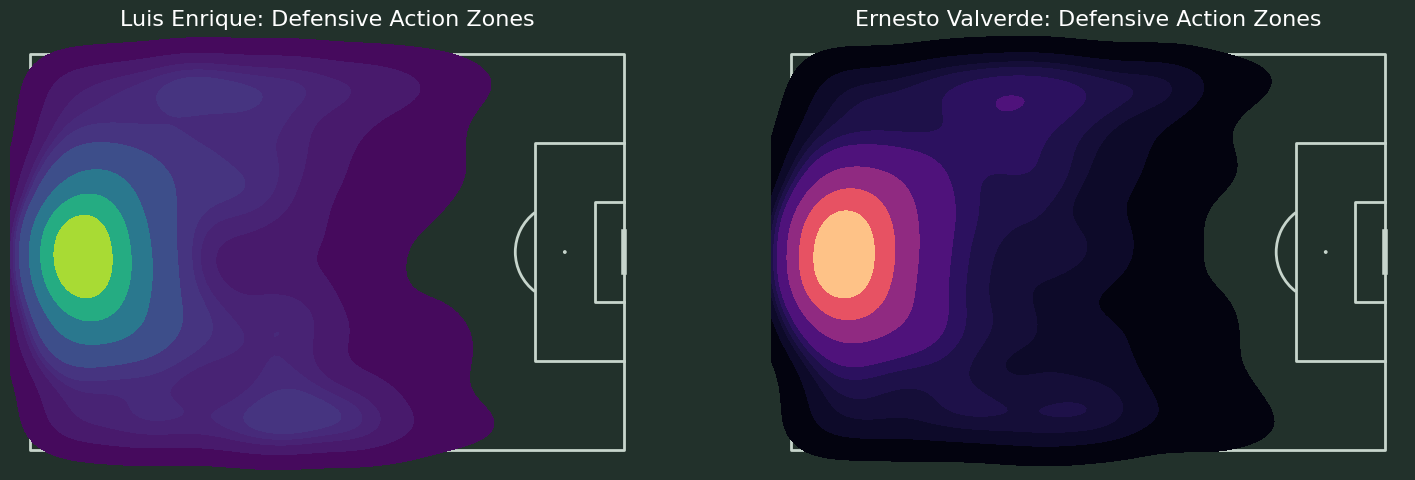

In [7]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, axs = pitch.draw(ncols=2, figsize=(18, 9), constrained_layout=True, tight_layout=False)
fig.set_facecolor("#22312b")

#  Luis Enrique Defensive Heatmap
sns.kdeplot(
    x=luis_defensive_actions['location_x'],
    y=luis_defensive_actions['location_y'],
    fill=True, cmap='viridis', thresh=0.05, ax=axs[0]
)
axs[0].set_title("Luis Enrique: Defensive Action Zones", color='white', size=16)

#  Ernesto Valverde Defensive Heatmap
sns.kdeplot(
    x=valverde_defensive_actions['location_x'],
    y=valverde_defensive_actions['location_y'],
    fill=True, cmap='magma', thresh=0.05, ax=axs[1]
)
axs[1].set_title("Ernesto Valverde: Defensive Action Zones", color='white', size=16)

plt.show()


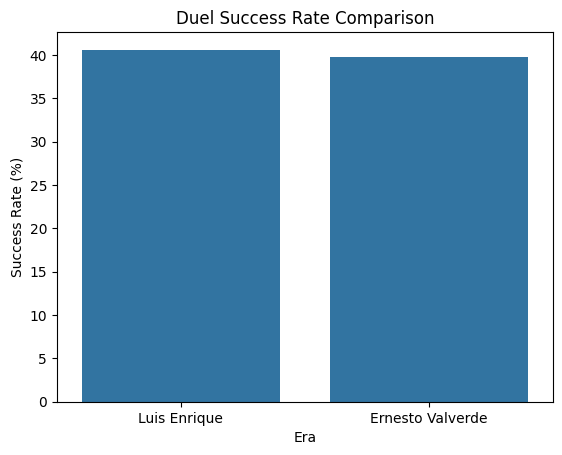

In [8]:
#  Calculate Duel Success Rate
def get_duel_success_rate(df):
    duels = df[df['event_type'] == 'Duel'].dropna(subset=['duel_outcome'])
    # Define success based on your data's values
    successful_outcomes = ['Won', 'Success In Play', 'Success Out']
    successful_duels = duels[duels['duel_outcome'].isin(successful_outcomes)]
    return (len(successful_duels) / len(duels)) * 100

luis_duel_rate = get_duel_success_rate(df_luis)
valverde_duel_rate = get_duel_success_rate(df_valverde)

#  Visualization
duel_data = {'Era': ['Luis Enrique', 'Ernesto Valverde'], 'Success Rate (%)': [luis_duel_rate, valverde_duel_rate]}
df_duel_rates = pd.DataFrame(duel_data)

sns.barplot(x='Era', y='Success Rate (%)', data=df_duel_rates)
plt.title('Duel Success Rate Comparison')
plt.show()


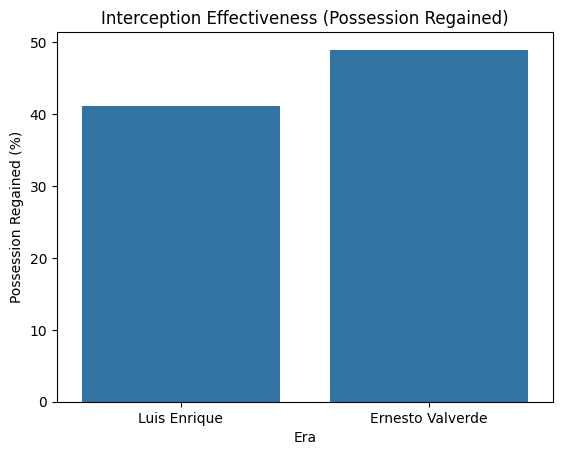

In [9]:
#  Calculate Interception Effectiveness
def get_interception_effectiveness(df):
    interceptions = df[df['event_type'] == 'Interception'].dropna(subset=['interception_outcome'])
    # Define outcomes where possession is kept
    possession_kept_outcomes = ['Won', 'Success In Play']
    effective_interceptions = interceptions[interceptions['interception_outcome'].isin(possession_kept_outcomes)]
    return (len(effective_interceptions) / len(interceptions)) * 100

luis_interception_rate = get_interception_effectiveness(df_luis)
valverde_interception_rate = get_interception_effectiveness(df_valverde)

#  Visualization Graph
interception_data = {'Era': ['Luis Enrique', 'Ernesto Valverde'], 'Possession Regained (%)': [luis_interception_rate, valverde_interception_rate]}
df_interception_rates = pd.DataFrame(interception_data)

sns.barplot(x='Era', y='Possession Regained (%)', data=df_interception_rates)
plt.title('Interception Effectiveness (Possession Regained)')
plt.show()


In [10]:
# Filter for clearances
luis_clearances = df_luis[df_luis['event_type'] == 'Clearance']
valverde_clearances = df_valverde[df_valverde['event_type'] == 'Clearance']

# Compare total counts and average location
print(f"Total Clearances (Enrique): {len(luis_clearances)}")
print(f"Average Clearance X-Location (Enrique): {luis_clearances['location_x'].mean():.2f}")

print(f"\nTotal Clearances (Valverde): {len(valverde_clearances)}")
print(f"Average Clearance X-Location (Valverde): {valverde_clearances['location_x'].mean():.2f}")


Total Clearances (Enrique): 2588
Average Clearance X-Location (Enrique): 16.88

Total Clearances (Valverde): 1675
Average Clearance X-Location (Valverde): 15.47


In [12]:
from scipy.stats import gaussian_kde
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mplsoccer import Pitch

def create_defensive_zones(df, coach_name):
    # Calculate 2D density over the whole dataset
    x = df['location_x']
    y = df['location_y']
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Add the density to the original DataFrame
    df = df.copy()  # preventing mutating original
    df['density'] = z

    # Find top 10% density areas (hotspots)
    threshold = np.percentile(z, 90)
    hotspots = df[df['density'] > threshold]

    # Calculate centroid of defensive actions
    centroid_x = hotspots['location_x'].mean()
    centroid_y = hotspots['location_y'].mean()

    # Plot
    pitch = Pitch(pitch_type='statsbomb')
    fig, ax = pitch.draw()
    sns.scatterplot(
        x='location_x', y='location_y',
        data=hotspots,
        hue='density',
        palette='viridis',
        ax=ax
    )
    ax.scatter(centroid_x, centroid_y, s=300, marker='x', c='red')
    ax.set_title(f"{coach_name} Defensive Hotspots\nCentroid: ({centroid_x:.1f}, {centroid_y:.1f})")
    plt.show()

    return centroid_x, centroid_y


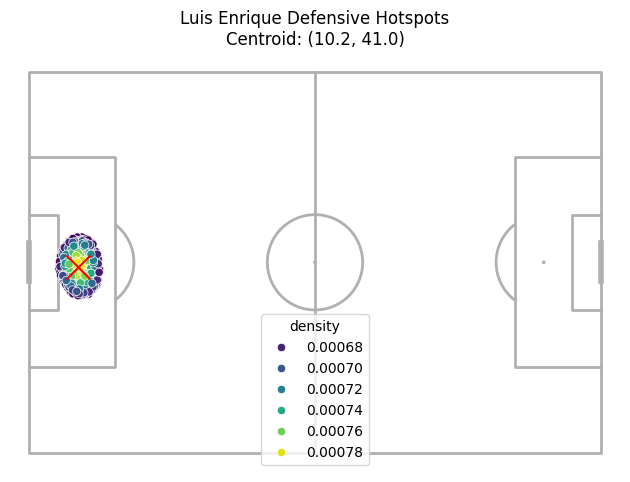

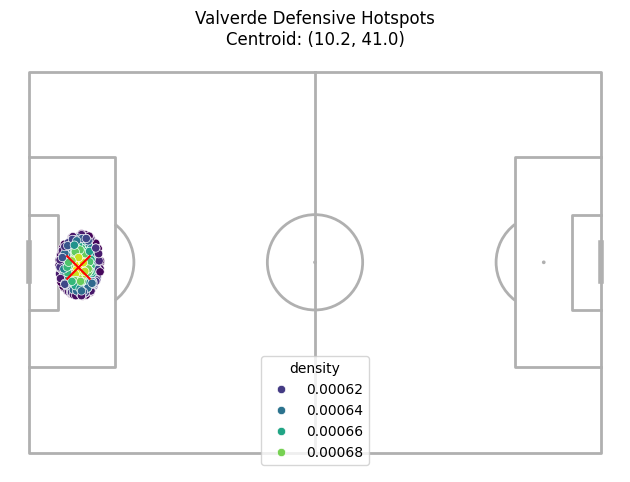

Luis Enrique centroid: (np.float64(10.182985074626867), np.float64(41.01597014925373))
Valverde centroid: (np.float64(10.177692307692308), np.float64(40.988653846153845))


In [14]:
# Compare defensive centroids
le_centroid = create_defensive_zones(luis_defensive_actions, "Luis Enrique")
ev_centroid = create_defensive_zones(valverde_defensive_actions, "Valverde")
print(f"Luis Enrique centroid: {le_centroid}")
print(f"Valverde centroid: {ev_centroid}")


# Conclusion:

 Defensive Philosophies Compared Luis Enrique vs Ernesto Valverde
While both Luis Enrique and Ernesto Valverde deployed defensively solid Barcelona sides, their underlying defensive behaviors tell subtly different stories.

Luis Enrique's team showed a broader and more advanced defensive footprint, particularly down the left channel. This suggests a higher pressing structure with fullbacks and midfielders engaging early to regain possession. The defensive heatmap under his tenure reflects a willingness to push up and defend proactively  defnding by attacking, in essence.

In contrast, Ernesto Valverde's Barcelona leaned toward a more compact, vertically narrow setup. Defensive actions were clustered deeper, indicating a preference for strctred mid_blocks and positional discipline. The higher interception efectiveness (49% vs Enrique's 41%) supports this  Valverde's system was more efective at regaining control once space was conceded.

Despite nearly identical centroids a result of overlapping defensive zones  the difference in shpe, density, and tactical intent becomes clear when heatmaps and outcomes ar layered in. Duel success rates were near identical, implying both coache relie on similarly capable personnel or defensive roles but the efficiency post intrcpt separates them.

Ultimately, Enrique's side defended through aggression and territory, while Valverde's approach leaned on structure and efficiency. The numbers and visuals align to paint two sides of the same defensive coin proactive vs reactive control.